In [ ]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import json

In [114]:

def get_graph_paths(dataset_dir= "./datasets/"):
    graph_list = []
    for dirpath, _, files in os.walk(dataset_dir):
        for filename in files:
            try:
                if filename.endswith(".edges"):
                    file_path = os.path.join(dirpath, filename) 
                    graph_list.append((file_path, os.path.splitext(filename)[0]))
            except Exception as e: 
                print(e, f'{filename}')
    return graph_list


def get_sir_graph_paths(net_name, num_b=3,  result_path = './datasets/SIR_Results/'):
    paths= []
    for i in range(num_b):
        sir_dir =os.path.join(result_path, net_name)
        sir_dir = os.path.join(sir_dir, f'{i}.csv')
        paths.append(sir_dir)
    return paths


In [115]:

def SIR(G, infected, B_values, gama=1.0, num_iterations=100, num_steps=200):
    num_nodes = G.number_of_nodes()
    affected_scales = {}
    infected_scales = {}
    for B in B_values:
        recovered_sum = 0  # To store the sum of recovered nodes across all iterations
        infected_sum = 0

        # Store trends for plotting
        trends = []

        for i in range(num_iterations):
            # Initialize the SIR model
            model = ep.SIRModel(G)
            
            # Configuration setup
            config = mc.Configuration()
            config.add_model_parameter('beta', B)  # Set infection rate to current B
            config.add_model_parameter('gamma', gama)  # Recovery probability = 1
            # config.add_model_initial_configuration("Infected",  {0: 1})  # Start with node 0 infected
            config.add_model_initial_configuration("Infected",  infected)  
            
            # Set the model configuration
            model.set_initial_status(config)
            
            
            iteration = None
            # Run the model until all nodes are either recovered or susceptible
            for step in range(num_steps):  # Maximum 200 steps
                iteration = model.iteration()
                trends.append(model.build_trends([iteration]))
                
                # Check if all nodes are either recovered or susceptible (no infected nodes left)
                if iteration['node_count'][1] == 0:  # Index 1 corresponds to 'Infected'
                    break  # Exit the loop if no infected nodes remain

            # Get the final state after the infection spread
            final_state = iteration['node_count']
            recovered_nodes = final_state[2]  # Index 2 represents 'Recovered' nodes
            recovered_sum += recovered_nodes
            infected_sum += final_state[1]# Index 1 represents 'inffected' nodes
        
        # Calculate the affected scale for the current B
        affected_scale = recovered_sum / (num_iterations * num_nodes)
        affected_scales[B] = round(affected_scale, 5)
        infected_scales[B] = infected_sum 
    return affected_scales, infected_scales


In [ ]:
def analyze_sir_vs_iterations(net_name, G, infected_nodes, B_values, gama, num_iterations_list, num_steps=200):
    plt.figure(figsize=(10, 6))

    for node in infected_nodes:
        infected = {node: 1}
        average_sir_values = []

        for num_iterations in num_iterations_list:
            affected_scales, _ = SIR(G, infected, B_values, gama, num_iterations, num_steps)
            average_sir_value = sum(affected_scales.values()) / len(B_values)
            average_sir_values.append(average_sir_value)

        plt.plot(num_iterations_list, average_sir_values, marker='o', label=f"Node {node}")

    plt.title(f"SIR Value over Iterations: {net_name}")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Average SIR Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./sir_labeling/images/iterations/sir_val_over_iter_{net_name}.png", dpi=300, bbox_inches='tight')
    plt.show()



def choose_random_node(G):
    return random.choice(list(G.nodes))


def get_B_Value(G, num_b=3):
    # Get the mean degree (k) of the graph
    degrees = [deg for _, deg in G.degree()]
    
    # First moment (mean degree)
    mean_degree = np.mean(degrees)

    # Second moment (mean of squared degrees)
    mean_degree_squared = np.mean([deg**2 for deg in degrees])

    # Epidemic threshold (B_Threshold)
    B_Threshold = mean_degree / (mean_degree_squared - mean_degree)
    # Range of B values
    B_values = np.linspace(1 * B_Threshold, 2 * B_Threshold, num_b)
    # Use numpy's round function
    B_values = np.round(B_values, 3)
    B_values = B_values.tolist()
    return B_values

ba_edgelist_1000_10
Selected nodes: [209, 259, 378]


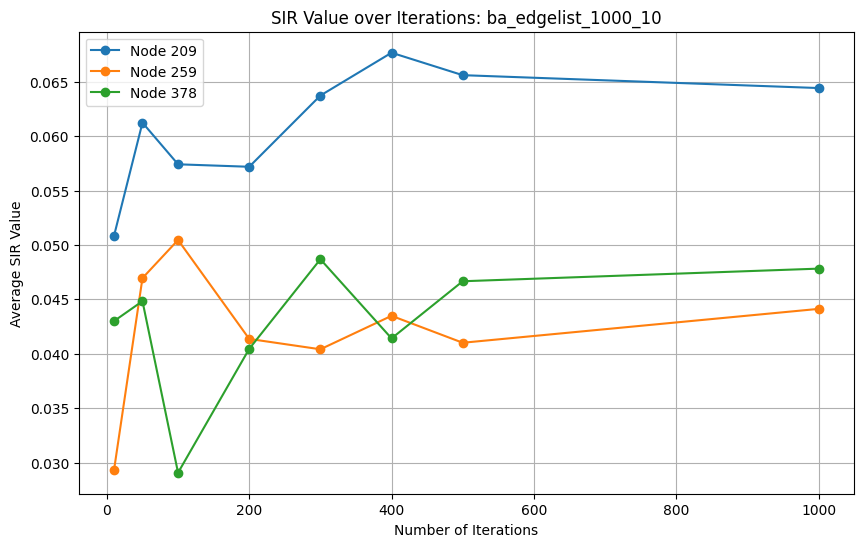

In [ ]:
graph_list = get_graph_paths()
# Example usage

for graph in graph_list:
    G_path = graph[0]
    print(graph[1])
    G = nx.read_edgelist(G_path, comments="%", nodetype=int)
    
    # Choose 3 random nodes
    infected_nodes = [choose_random_node(G) for _ in range(3)]
    print("Selected nodes:", infected_nodes)

    B_values = get_B_Value(G)
    gama = 1.0
    num_iterations_list = [10, 50, 100, 200, 300, 400, 500, 1000]   # you may wonder why i removed the 1000 element of the list, honey running this simulation took 2 minutes and 15 seconds for the smallest of my graphs
    analyze_sir_vs_iterations(graph[1], G, infected_nodes, B_values, gama, num_iterations_list)
    

   
`num_iterations_list = [10, 50, 100, 200, 300, 400, 500, 1000]   
`    

- you may wonder why i removed the 1000 element of the list, honey running this simulation took 2 minutes and 15 seconds for the smallest of my graphs